<p style="text-align:center; font-size:x-large; color:black;">AR(p) Models</p>
<hr>

In this file, I will try to fit an __Auto-Regressive (AR)__ model on the trading volumes of T-Mobile (NYSE: TMUS). High trading volume generally indicates increased market activity and interest in a particular asset, so it may be of use if we can develop a prediction of what future trading volumes are going to be. <br><br>
Before going further, I am going to grab some stock data with the YahooFinance API. 

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf

In [4]:
tmus = yf.Ticker("TMUS")
data = tmus.history(period="3y")
data = data.drop(columns = ['Open', 'High', 'Low', 'Close', 'Dividends', 'Stock Splits'])
data.index = range(len(data))
data

,Volume
0,2721700
1,3008600
2,2011400
3,3401800
4,4138400
...,...
750,3246600
751,5005900
752,3701900
753,4165100


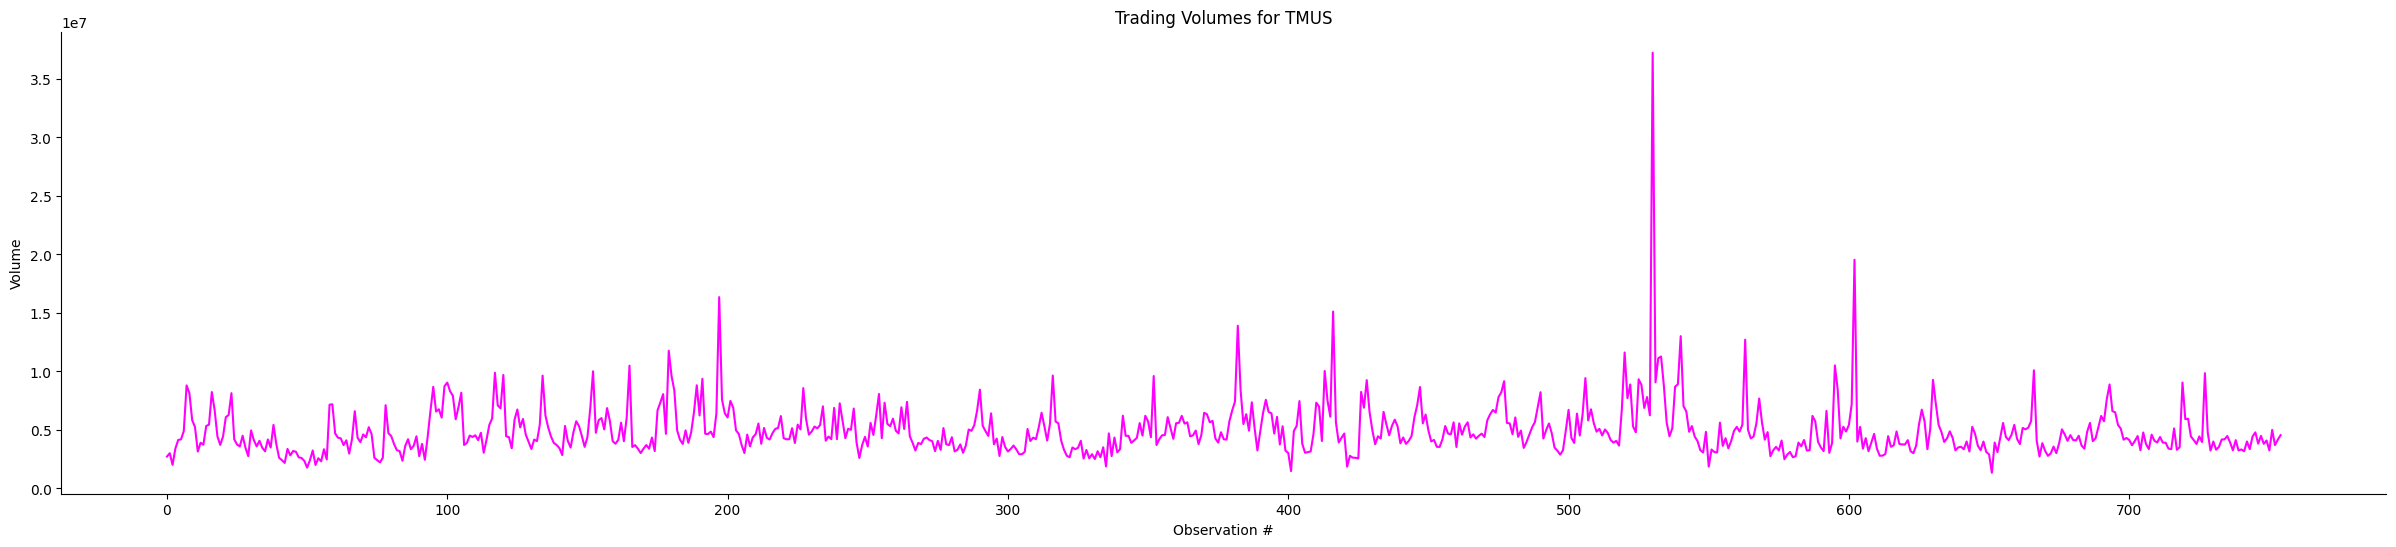

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (30,6))
plt.plot(data.index, data['Volume'], color = 'magenta')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('Trading Volumes for TMUS')
plt.xlabel('Observation #')
plt.ylabel('Volume')
plt.show()

<p style="text-align:left; font-size:x-large; color:black;">The Math Behind AR(p) Models</p>

An AR model is a type of stationary time series model where the current value is based on its previous values. We can imagine it as a multiple (or single) linear regression over time, where our predictor variables are previous values. The lag __p__ denotes how many past values we are using at predictors for this regression. In equational form, an AR(p) model is the following...

$$
r_{t} = \phi_{0} + \phi_{1}r_{t-1} + \phi_{2}r_{t-1} + \cdots + \phi_{p}r_{t-p} + \epsilon_{t}
$$

&epsilon;<sub>t</sub> is a random value drawn from a __White Noise__ process. A white noise process is a sequence of random variables with mean 0 and finite variance, that have no correlation between successive values. In other words, there is no way of predicting future values of &epsilon;<sub>t</sub>. We can imagine this as the residuals of a linear regression over time. <br><br>
It's in the word itself, but stationary time-series models like AR(p), MA(q) and ARMA(p,q) are __weak stationarity__. This means that the mean and variance of our process is invariant of time. In other words,
$$
E[r_{t}] = E[r_{t - 1}] = E[r_{t - 2}] = \cdots
$$
$$
var[r_{t}] = var[r_{t - 1}] = var[r_{t - 2}] = \cdots
$$
Through some manupulation and the requirement of weak stationarity, we can develop an overall expecation and variance for the process r<sub>t</sub>.
$$
E[r_{t}] = \frac{\phi_{0}}{\phi_{1} + \phi_{2} + \cdots + \phi_{p}}
$$
$$
Var[r_t] = \frac{\sigma_{\epsilon}^{2}}{1 - \phi_{1}^{2} - \phi_{2}^{2} - \cdots - \phi_{p}^{2}}
$$
Since our model coefficients (&phi;s) aren't changing, these formulas for the mean and variance of our AR(p) process show weak stationarity.

<p style="text-align:left; font-size:x-large; color:black;"> PACFs </p>

When fitting an AR(p) process to a time-series, we don't know what the order (p) is yet. To determine p it's useful to look at the __Partial Auto-Correlation Function (PACF)__ values. The partial autocorrelation tells us the direct relationship between a specific time point in a time series and its lagged values, while not worrying about influence of the other lagged values up to that lag. In other words...

$$
\text{Partial Autocorrelation for lag k} = Corr(r_{t}, r_{t - k} | r_{t-1}, r_{t-2}, \cdots, r_{t - k + 1})
$$

Since an AR(p) model is essentially a regression on the p past values, the partial autocorrelation for any lag beyond p should be 0. Therefore, to determine the order of our AR model, we should examine the PACF plot and see where the PACF values abruptly become insignificant.
- Side Note: It's assumed that the sample PACF value we get is a normally distributed value with mean 0 and variance 1/T where T is the number of values in the time-series.

<p style="text-align:left; font-size:x-large; color:black;">Putting it Together in Python</p>

First, lets split our time-series into __training__ and __testing__ data. This is so that we can fit an AR(p) model on our testing data, and then test our fitted model's predictive capability on our testing set.

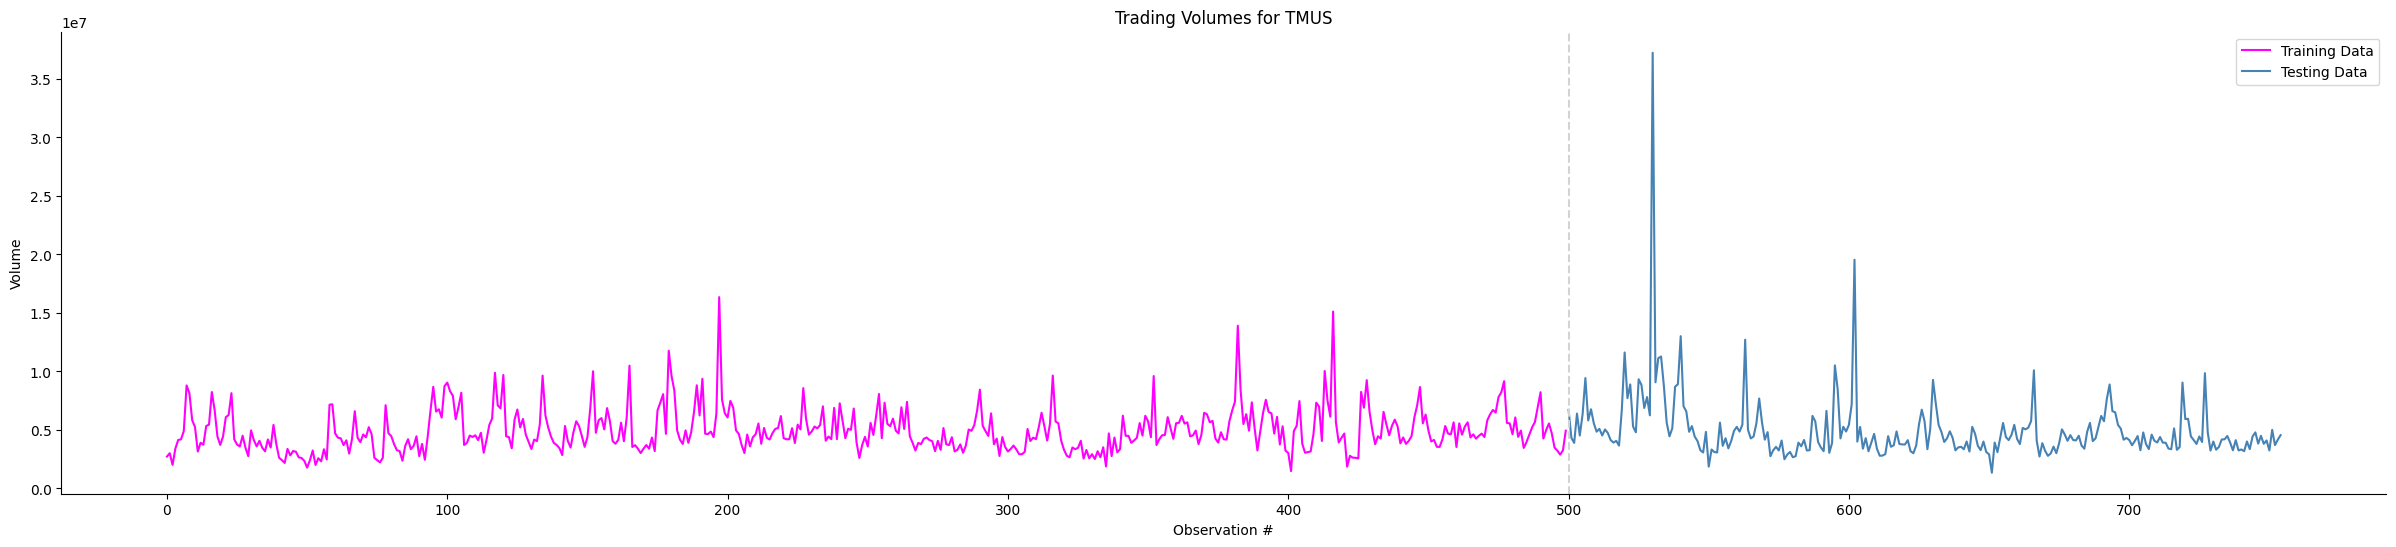

In [6]:
training_data = data.iloc[:500]
testing_data = data.iloc[500:]

fig = plt.figure(figsize = (30,6))
plt.plot(training_data.index, training_data['Volume'], color = 'magenta', label = 'Training Data')
plt.plot(testing_data.index, testing_data['Volume'], color = 'steelblue', label = 'Testing Data')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('Trading Volumes for TMUS')
plt.xlabel('Observation #')
plt.legend()
plt.axvline(500, color = 'lightgray', linestyle = '--')
plt.ylabel('Volume')
plt.show()

From here, we will just look at the training data. If we are attempting to fit an AR(p) process (A stationary process), we should probably check that our time-series is stationary. By looking at the above plot, we can roughly see a constant mean and variance within the training data. To make sure that we are seeing weak stationarity, we can utilize the __Augmented Dickey-Fuller (ADF)__ test, which is a statistical test for stationarity. If the p-value is less than a desired significance level, we reject the ADF's null hypothesis of non-stationarity.

In [11]:
from statsmodels.tsa.stattools import adfuller
print(f'P-Value: {adfuller(training_data['Volume'])[1]}')

P-Value: 1.3579154404951891e-17


From this test, we can assume that our training data is stationary, so we don't need to apply any transformations to make it so. Now we can go ahead and analyze the PACF.

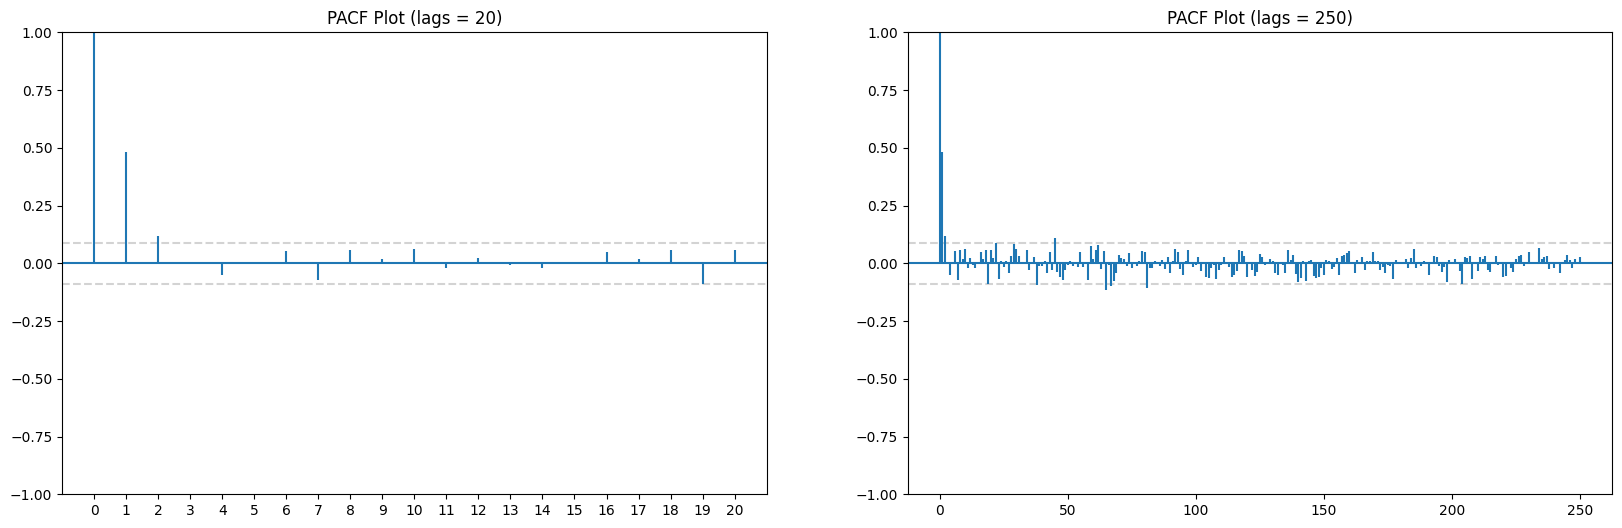

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

T = len(training_data)

fig, ax = plt.subplots(1,2,figsize = (20,6))

ax[0].axhline(1.96 / np.sqrt(T), color = 'lightgray', linestyle = '--')
ax[0].axhline(-1.96 / np.sqrt(T), color = 'lightgray', linestyle = '--')
plot_pacf(training_data['Volume'], marker = 'None', lags = 20, alpha = 0, ax = ax[0])
ax[0].set_xticks(range(21))
ax[0].set_title('PACF Plot (lags = 20)')

ax[1].axhline(1.96 / np.sqrt(T), color = 'lightgray', linestyle = '--')
ax[1].axhline(-1.96 / np.sqrt(T), color = 'lightgray', linestyle = '--')
plot_pacf(training_data['Volume'], marker = 'None', alpha = 0, lags = T/2, ax = ax[1])
ax[1].set_title('PACF Plot (lags = 250)')

plt.show()

We can see that the significant partial autocorrelations (above the bars) drop off after lag 2. This suggests that we can try to implement an AR(2) process to model the training data. We can also use a special python function to figure out which order is the most ideal.

In [12]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
selector = ar_select_order(training_data['Volume'], 200)
print(selector.ar_lags)
print(f'Therefore best lag for AR(p) is p = {np.max(selector.ar_lags)}')

[1, 2]
Therefore best lag for AR(p) is p = 2


After deciding the number of lags we want to use, we can now fit an AR model using python's __ARIMA__ model. This takes in 3 parameters: p (the auto-regressive order), d (the differencing order), and q (the moving average order). Since we are only fitting an AR(2) model, our order will be (2, 0, 0).

In [40]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(training_data['Volume'], order=(2, 0, 0)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  500
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7854.089
Date:                Wed, 24 Apr 2024   AIC                          15716.178
Time:                        19:50:55   BIC                          15733.036
Sample:                             0   HQIC                         15722.793
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.937e+06   1.71e+05     28.911      0.000     4.6e+06    5.27e+06
ar.L1          0.4259      0.036     11.682      0.000       0.354       0.497
ar.L2          0.1204      0.041      2.971      0.0

By looking at the model summary, we can see that our training data is assumed to follow the following AR(2) process...

$$
r_{t} = (4.937 * 10^{6}) + 0.4259(r_{t-1}) + 0.1204(r_{t-2}) + \epsilon_{t}
$$

where &epsilon;<sub>t</sub> has variance 2.579e12.

Instead of relying on a pre-built python function, I am first going to define my own method to predict future values to show what's going on.
$$
r_t = \phi_{0} + \phi_{1}r_{t-1} + \phi_{1}r_{t-2} + \cdots + \phi_{1}r_{t-p} + \epsilon_{t}
$$

$$
E[r_{t} | r_{t-1} \cdots r_{t-p}] = \hat{r_{t}} = \phi_{0} + \phi_{1}r_{t-1} + \phi_{1}r_{t-2} + \cdots + \phi_{1}r_{t-p} = \phi_{0} + 

\begin{pmatrix}
\phi_{1} \\
\vdots \\
\phi_{p} \\
\end{pmatrix}
\cdot 
\begin{pmatrix}
r_{t-1} \\
\vdots \\
r_{t-p} \\
\end{pmatrix}
$$

In [15]:
# Training Data Forecasts
rhats = []

# First get rid of terms where p-values > 0.05
for j in range(len(model.pvalues)):

    if model.pvalues.iloc[j] > 0.05:
        model.params.iloc[j] = 0
    
const = model.params.iloc[0]
regressor_coefs = model.params.iloc[1: len(model.params) - 1].values
AR_order = 2

# Now re-iterate predictions based on ACTUAL data
for i in range(AR_order, len(training_data)):
    
    past_values = data.loc[i - AR_order : i - 1].iloc[::-1].values.flatten()
    rhat = const + np.dot(regressor_coefs, past_values)

    rhats.append(rhat)

rhats = pd.Series(rhats)
rhats.index = range(AR_order, len(training_data))

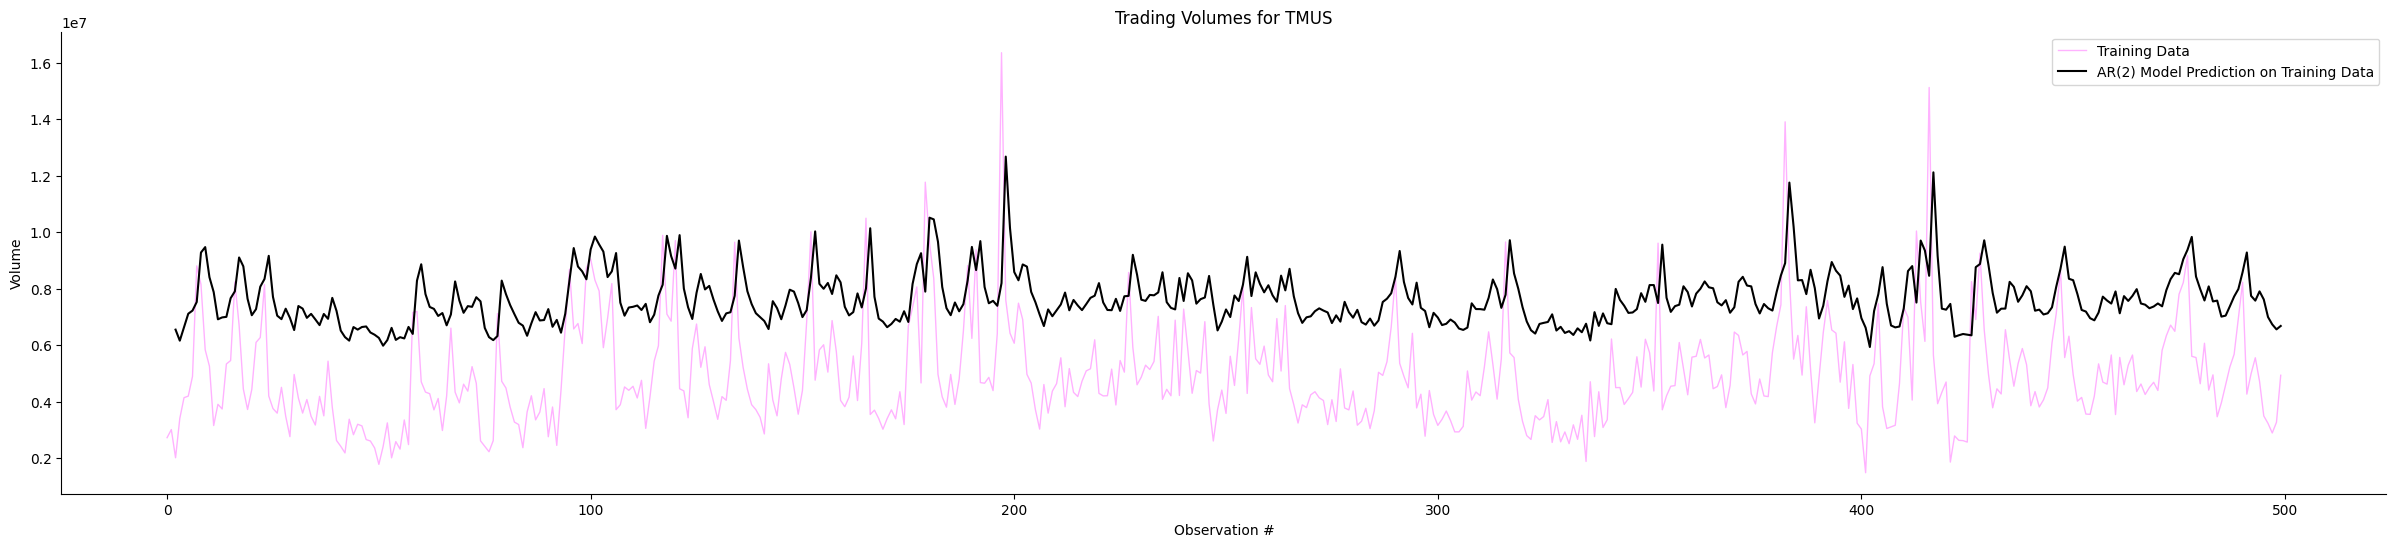

In [16]:
fig = plt.figure(figsize = (30,6))
plt.plot(training_data.index, training_data['Volume'], color = 'magenta', linewidth = 1, alpha = 0.3, label = 'Training Data')
plt.plot(rhats.index, rhats, color = 'black', label = 'AR(2) Model Prediction on Training Data')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('Trading Volumes for TMUS')
plt.xlabel('Observation #')
plt.legend()
plt.ylabel('Volume')
plt.show()

<p style="text-align:left; font-size:x-large; color:black;">Residual Analysis</p>

Now that we have our predictions, we can analyze the residuals.
$$
\text{Residual}_{t} = r_{t} - \hat{r_{t}}
$$

In [18]:
residuals = (training_data['Volume'].iloc[AR_order:] - rhats).values
print(f'mean of residuals = {np.mean(residuals)}')
print(f'variance of residuals = {np.var(residuals)}')

mean of residuals = -2691241.9925012523
variance of residuals = 2579042612159.731


This is an approximation of the __sigma2__ that is apparent in our model summary. As stated, within an AR(p) model, the residuals are supposed to follow a white noise process. While the mean of our residuals is non-zero, we need to test if this non-zero mean is statistically significant. We can do this through a __One-Sample T-test__.
$$
\text{H}_{0}: \mu = 0
$$
$$
\text{H}_{A}: \mu \neq 0
$$

In [51]:
from scipy import stats

t_test_result = stats.ttest_1samp(residuals, 0)

print(f'P-Value = {t_test_result[1]}')

P-Value = 1.3046525758222325e-38


Since the p-value is super close to 0, we have evidence to suggest that the mean of our residuals is non-zero. For the sake of demonstration though, I will show how to check the residuals follow the other assumptions of a white noise process.

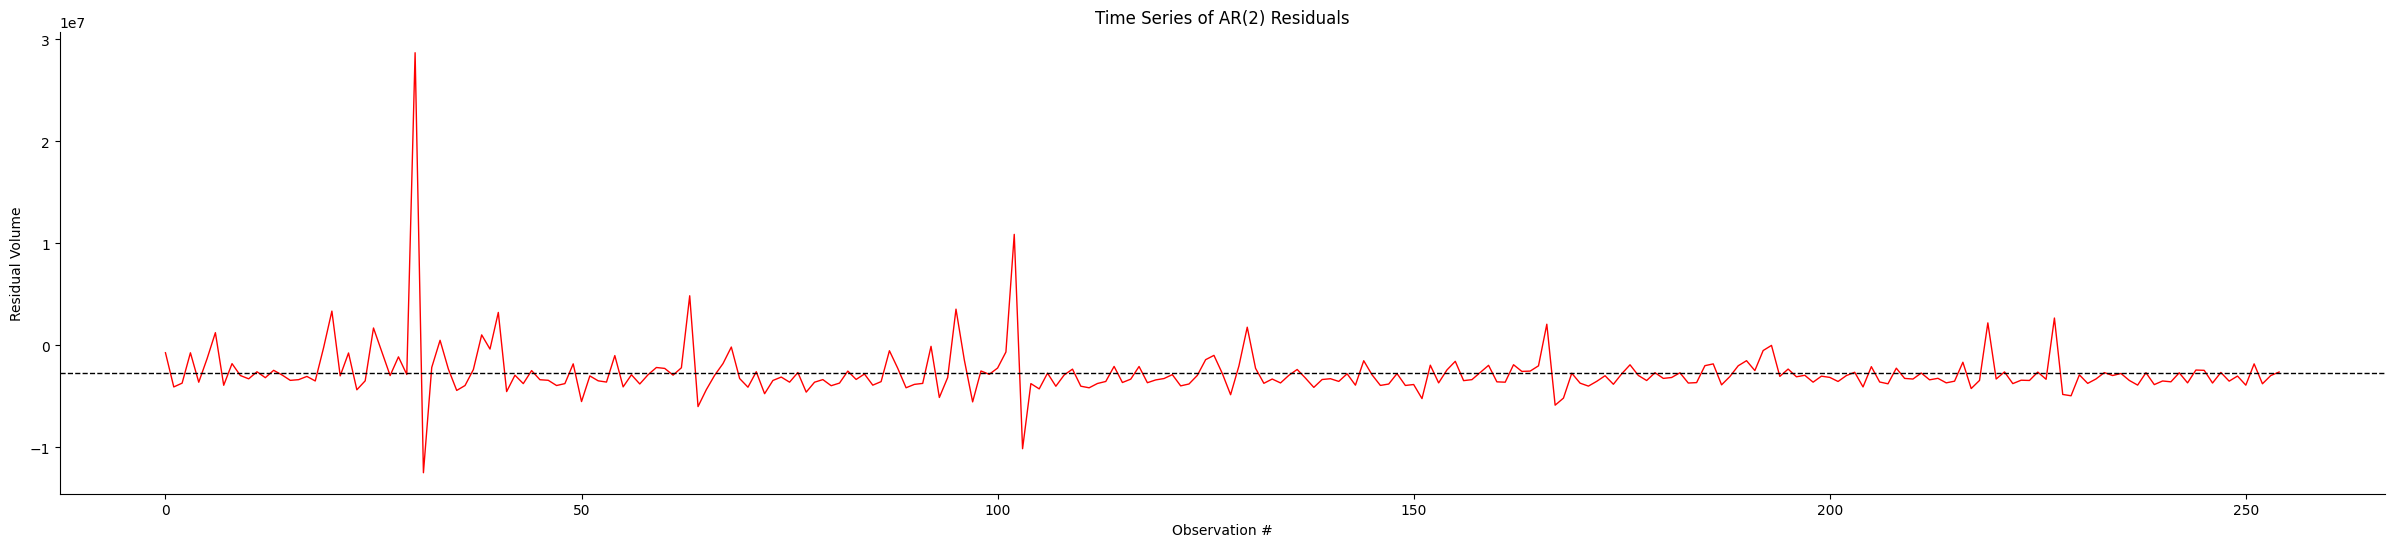

In [53]:
fig = plt.figure(figsize = (30,6))
plt.plot(residuals, color = 'red', linewidth = 1)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Time Series of AR(2) Residuals')
plt.xlabel('Observation #')
plt.ylabel('Residual Volume')
plt.axhline(np.mean(residuals), color = 'black', linestyle = '--', linewidth = 1)
plt.show()


First I'll show the 'identical distribution' part. To check this, we cana utilize the __Kolmogorov-Smirnov__ test. This is anon-parametric test used to compare the cumulative distribution functions (CDFs) of two samples. If the p-value of the KS Test is below a chosen significance level, we can reject the null hypothesis and conclude that the distributions of the two samples are different.

In [26]:
from scipy import stats

# Split the residuals array into two random samples
residuals_copy = residuals
np.random.shuffle(residuals_copy)

sample1 = residuals_copy[:len(residuals_copy)//2]
sample2 = residuals_copy[len(residuals_copy)//2:]

# Perform KS Test
ks_statistic, p_value = stats.ks_2samp(sample1, sample2)
p_value

0.8874650165235428

This means that our random samples most likely come from the same distribution, so we can assume that our residuals are identically distributed. We can also employ a __heteroscedacity__ test. Heteroscedacity means the the variance is changing over time, while homoscedacity means constant variance. To test for heteroscedacity, we can use the __Breusch-Pagan__ test, otherwise known as the H test. If the p-value is below a chosen significance level, heterosceacity is likely present.

In [32]:
from statsmodels.stats.diagnostic import het_arch

lm, lm_p_value, fvalue, f_p_value = het_arch(residuals)
lm_p_value

0.6629742452250118

From this test, we can assume homoscedacity of our residuals, which means that the variance is constant.

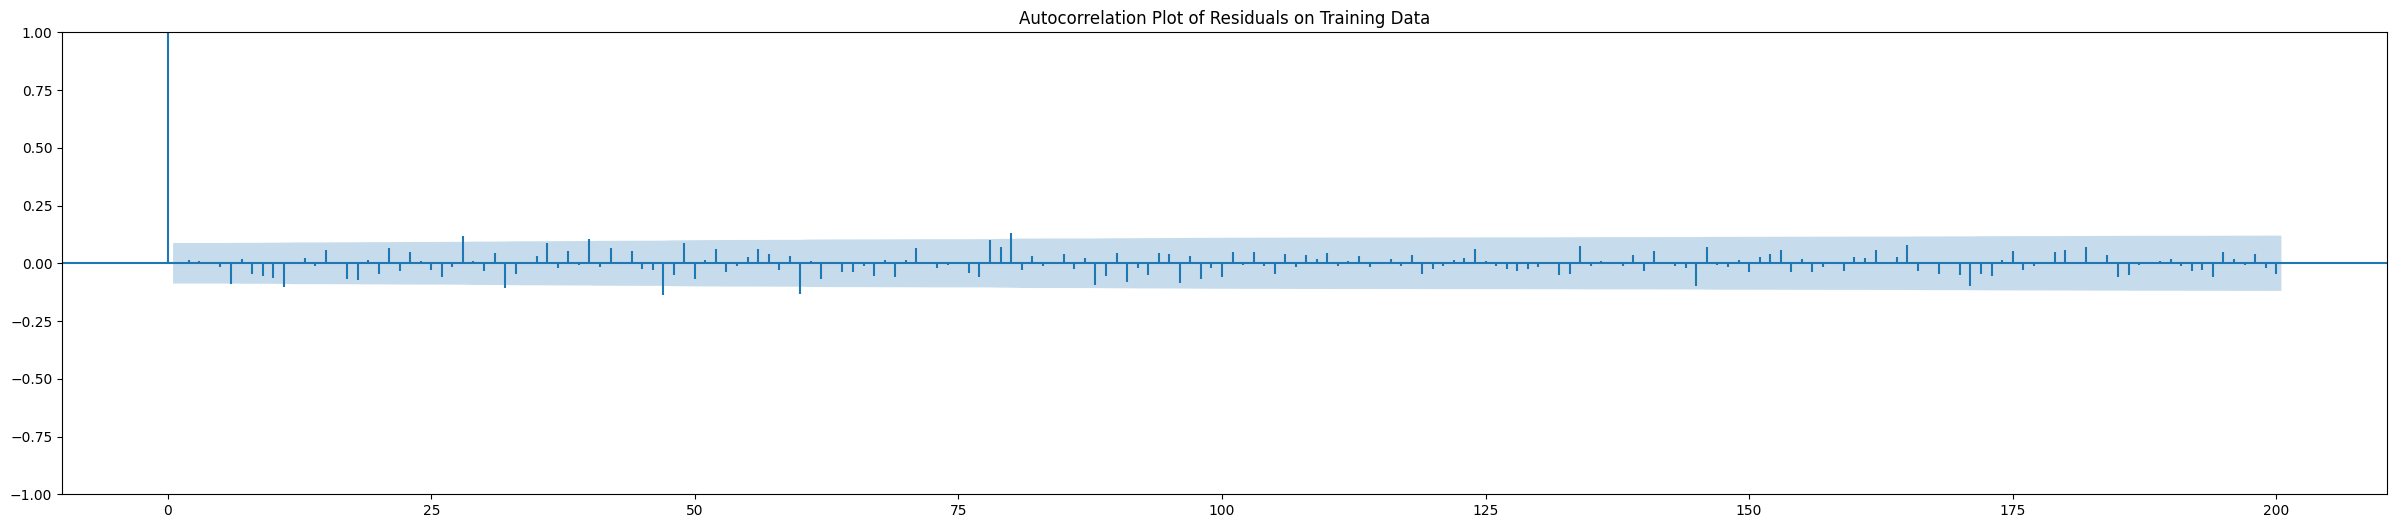

In [27]:
fig, ax = plt.subplots(1,1,figsize = (30,6))
plot_acf(residuals, lags = 200, marker = None, ax = ax)
plt.title('Autocorrelation Plot of Residuals on Training Data')
plt.show()

If we wanted to use a statistical test rather than a visualization, we can use the __Ljung-Box__ test, which tests for autocorrelation up to a certain number of lags.

In [37]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test_results = acorr_ljungbox(residuals, lags = 30)
lb_test_results

,lb_stat,lb_pvalue
1,0.001436,0.969775
2,0.074871,0.963257
3,0.127380,0.988360
4,0.127550,0.998051
5,0.276787,0.998057
6,4.206859,0.648705
7,4.414470,0.730991
8,5.538352,0.698787
9,7.036398,0.633330
10,9.033572,0.528920


The __Prob(Q)__ value in the model summary is based off the p-value at a certain lag (presumably 3 in this case).

What all of these visualizations/statistical tests on our model residuals. It is reasonable to conclude that our residuals don't follow a white noise process of any kind.

<p style="text-align:left; font-size:x-large; color:black;">Out-of-Sample Forecasts</p>

While it was useful to perform forecasts on the training data to assess the viability of an AR(p) model, what we really want is our model predictions on testing data. This is because we used the training data to form our model parameters in the first place. By making predictions on data that we used to fit the model, we would observe better-than-expected results.

Here is an example of code that uses the model parameters from our training data to make predictions on our testing data. Keep in mind that we have already proved that an AR(2) model is not sufficient, so this is just a demonstration.

In [42]:
# Testing Data Forecasts
rhats = []

# First get rid of terms where p-values > 0.05
for j in range(len(model.pvalues)):

    if model.pvalues.iloc[j] > 0.05:
        model.params.iloc[j] = 0

const = model.params.iloc[0]
regressor_coefs = model.params.iloc[1: len(model.params) - 1].values
AR_order = 2

# Now re-iterate predictions based on ACTUAL data
for i in range(len(testing_data)):
    
    past_values = data.loc[len(training_data) + i - AR_order : len(training_data) + i - 1].iloc[::-1].values.flatten()
    rhat = const + np.dot(regressor_coefs, past_values)

    rhats.append(rhat)

rhats = pd.Series(rhats)
rhats.index = testing_data.index


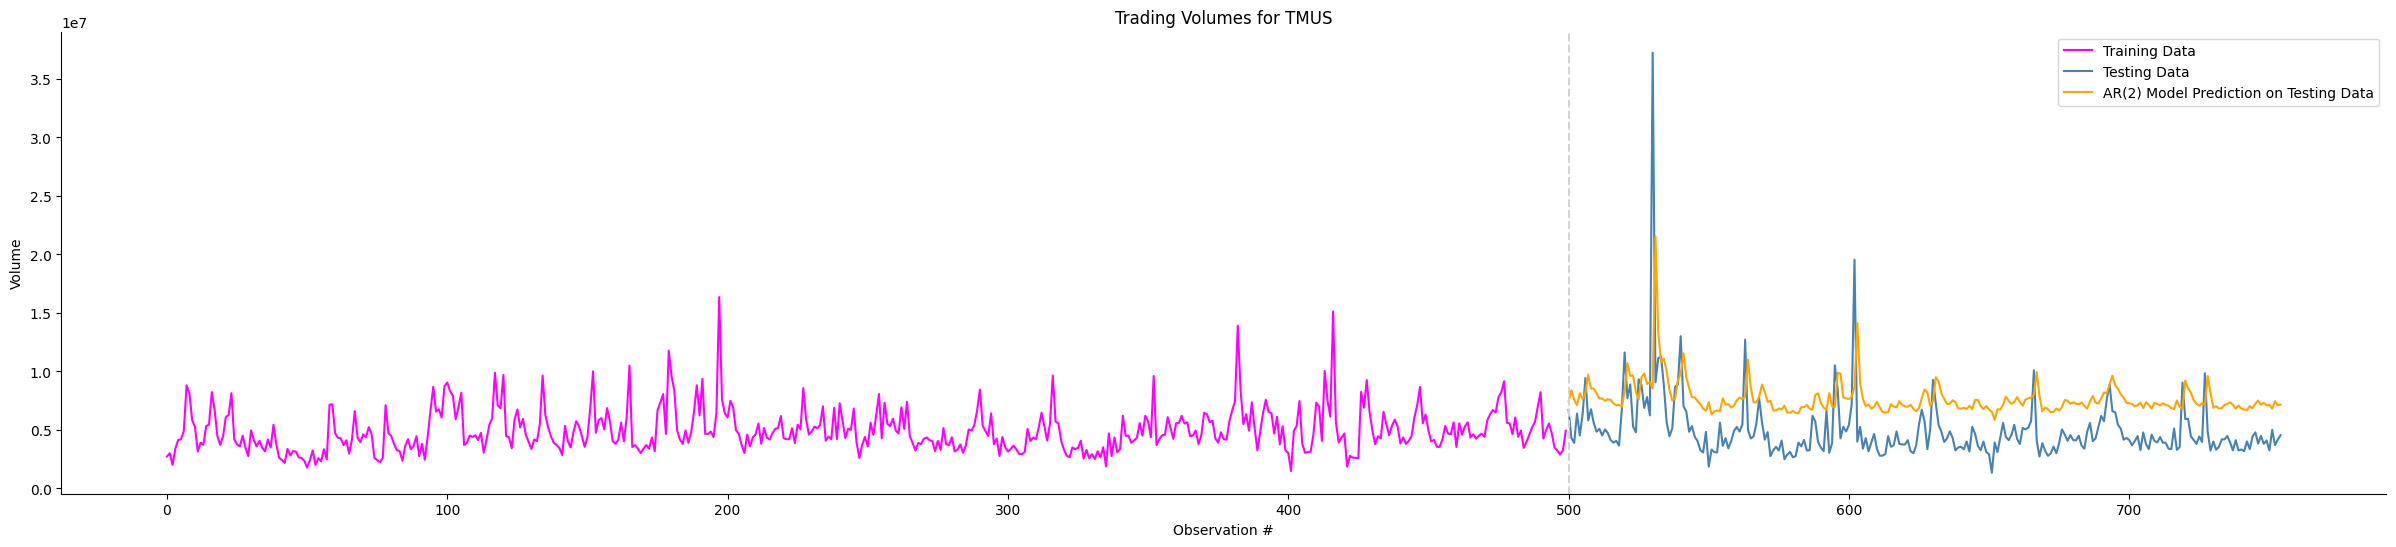

In [43]:
fig = plt.figure(figsize = (30,6))
plt.plot(training_data.index, training_data['Volume'], color = 'magenta', label = 'Training Data')
plt.plot(testing_data.index, testing_data['Volume'], color = 'steelblue', label = 'Testing Data')
plt.plot(rhats.index, rhats, color = 'orange', label = 'AR(2) Model Prediction on Testing Data')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('Trading Volumes for TMUS')
plt.xlabel('Observation #')
plt.legend()
plt.axvline(500, color = 'lightgray', linestyle = '--')
plt.ylabel('Volume')
plt.show()

Now if we calculate our residuals, we will obtain different values for the mean and varaicne of residuals.

In [44]:
residuals = (testing_data['Volume'] - rhats).values
print(np.var(residuals))

7565931779446.133


Now, the variance of our residuals is 3 times as much, but this is a much more accurate representation of the predictive performance of our current AR(2) model.